In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **데이터 크롤링**

In [ ]:
import json
import requests
import pandas as pd
from io import BytesIO
from datetime import datetime

In [ ]:
#URL로 POST 요청을 보내고 응답으로 받은 JSON 데이터를 pandas DataFrame으로 변환
headers = {'User-Agent': 'Chrome/111.0.0.0 Safari/537.36'}

data = {'mktsel': 'ALL',
        'typeNo': '0',
        'searchText': '',
        'bld': 'dbms/comm/finder/finder_stkisu'}

url = "http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd"

r = requests.post(url, data=data, headers=headers)
j = json.loads(r.text)

df = pd.json_normalize(j['block1'])
print(len(df))
print(df.iloc[1]['full_code'])

In [ ]:
#POST 요청을 보내고 응답으로 받은 JSON 데이터를 pandas DataFrame으로 변환
full_code = df.loc[df['short_code'] == '005930']['full_code'].values[0]

strtDd = '20220101'
endDd = '20230326'

data2 = {'bld': 'dbms/MDC/STAT/standard/MDCSTAT01701',
         'isuCd': full_code,
         'isuCd': full_code,
         'strtDd': strtDd,
         'endDd': endDd,
         'searchType': '2',
         'mktld': 'ALL',
         'csvxls_isNo': 'false'}

url2 = 'http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd'

r2 = requests.post(url2, data2, headers)
j2 = json.loads(r2.text)
df3 = pd.DataFrame(j2['output'])
df3

In [ ]:
full_code

# **데이터 전처리**

In [2]:
# TA-Lib 라이브러리를 다운로드하고 설치하는 작업을 수행
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4275    0  4275    0     0  13359      0 --:--:-- --:--:-- --:--:-- 13359
100  517k  100  517k    0     0   740k      0 --:--:-- --:--:-- --:--:--  740k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4287    0  4287    0     0  16362      0 --:--:-- --:--:-- --:--:-- 16300
100  392k  100  392k    0     0   664k      0 --:--:-- --:--:-- --:--:--  664k


In [3]:
import talib
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [10]:
#!unzip -qq '/content/drive/MyDrive/krx_daydata/KR_Data.zip'

In [29]:
%cd /content/drive/MyDrive/krx_daydata/Data

/content/drive/MyDrive/krx_daydata/Data


In [5]:
#KR7005930003.csv에서 필요로하는 열만 추출
dfdf = pd.read_csv('KR7005930003.csv')
dfdf = dfdf[['TRD_DD', 'ISU_CD', 'ISU_NM', 'TDD_CLSPRC', 'TDD_OPNPRC', 'TDD_HGPRC',
       'TDD_LWPRC', 'MKTCAP', 'ACC_TRDVOL']]
dfdf

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL
0,2022/01/11,5930,삼성전자,"78,900","78,400","79,000","78,000","471,015,843,195,000","13,221,123"
1,2022/01/10,5930,삼성전자,"78,000","78,100","78,100","77,100","465,643,038,900,000","9,947,422"
2,2022/01/07,5930,삼성전자,"78,300","78,100","78,400","77,400","467,433,973,665,000","15,163,757"
3,2022/01/06,5930,삼성전자,"76,900","76,700","77,600","76,600","459,076,278,095,000","12,931,954"
4,2022/01/05,5930,삼성전자,"77,400","78,800","79,000","76,400","462,061,169,370,000","25,470,640"
...,...,...,...,...,...,...,...,...,...
6757,1995/05/08,5930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000","91,810"
6758,1995/05/06,5930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000","47,440"
6759,1995/05/04,5930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500","175,590"
6760,1995/05/03,5930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500","382,980"


In [6]:
#데이터 타입이 'object'이고 'TRD_DD'와 'ISU_NM'이 아닌 열은 ,를 제거 후 부동 float 타입으로 변환
dfdf = dfdf.iloc[:]

for column in dfdf.columns:
    if dfdf[column].dtype == 'object' and column not in ['TRD_DD', 'ISU_NM']:
        try:
            dfdf[column] = dfdf[column].str.replace(',', '').astype('float')
        except ValueError as e:
            print(f" {column}: {e}")
    elif column not in ['TRD_DD', 'ISU_NM']:
        dfdf[column] = dfdf[column].astype('float')

dfdf

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL
0,2022/01/11,5930.0,삼성전자,78900.0,78400.0,79000.0,78000.0,4.710158e+14,13221123.0
1,2022/01/10,5930.0,삼성전자,78000.0,78100.0,78100.0,77100.0,4.656430e+14,9947422.0
2,2022/01/07,5930.0,삼성전자,78300.0,78100.0,78400.0,77400.0,4.674340e+14,15163757.0
3,2022/01/06,5930.0,삼성전자,76900.0,76700.0,77600.0,76600.0,4.590763e+14,12931954.0
4,2022/01/05,5930.0,삼성전자,77400.0,78800.0,79000.0,76400.0,4.620612e+14,25470640.0
...,...,...,...,...,...,...,...,...,...
6757,1995/05/08,5930.0,삼성전자,121000.0,122000.0,122000.0,120500.0,6.578606e+12,91810.0
6758,1995/05/06,5930.0,삼성전자,122000.0,122000.0,123500.0,122000.0,6.632975e+12,47440.0
6759,1995/05/04,5930.0,삼성전자,122500.0,124000.0,124500.0,122000.0,6.660159e+12,175590.0
6760,1995/05/03,5930.0,삼성전자,123500.0,119500.0,126500.0,119500.0,6.714528e+12,382980.0


In [7]:
list_value = ['TDD_CLSPRC', 'TDD_OPNPRC', 'TDD_HGPRC',
       'TDD_LWPRC', 'MKTCAP', 'ACC_TRDVOL']
#Min-Max 스케일링을 수행
scaler = MinMaxScaler()
for i in list_value:
    scaler.fit(pd.DataFrame(dfdf[i]))
    dfdf[i] = scaler.transform(pd.DataFrame(dfdf[i]))
df =pd.concat([dfdf['TRD_DD'],dfdf['ISU_CD'],dfdf['ISU_NM'],dfdf['TDD_CLSPRC'],dfdf['TDD_OPNPRC'],dfdf['TDD_HGPRC'],dfdf['TDD_LWPRC'],dfdf['MKTCAP'],dfdf['ACC_TRDVOL']],axis=1)
df

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL
0,2022/01/11,5930.0,삼성전자,0.016126,0.027270,0.027469,0.027484,0.866261,0.146403
1,2022/01/10,5930.0,삼성전자,0.015808,0.027165,0.027156,0.027167,0.856313,0.110152
2,2022/01/07,5930.0,삼성전자,0.015914,0.027165,0.027260,0.027273,0.859629,0.167915
3,2022/01/06,5930.0,삼성전자,0.015419,0.026678,0.026982,0.026991,0.844155,0.143201
4,2022/01/05,5930.0,삼성전자,0.015596,0.027409,0.027469,0.026920,0.849682,0.282048
...,...,...,...,...,...,...,...,...,...
6757,1995/05/08,5930.0,삼성전자,0.031015,0.042435,0.042420,0.042459,0.006373,0.001017
6758,1995/05/06,5930.0,삼성전자,0.031368,0.042435,0.042942,0.042988,0.006474,0.000525
6759,1995/05/04,5930.0,삼성전자,0.031545,0.043130,0.043289,0.042988,0.006524,0.001944
6760,1995/05/03,5930.0,삼성전자,0.031899,0.041565,0.043985,0.042107,0.006625,0.004241


In [13]:
df = df.sort_values(by=['TRD_DD'])
df.reset_index(drop=True,inplace=True)

#인풋 데이터 모양 맞춰주기(backtest에 들어갈 데이터 모양)
df_bt = df[['TRD_DD','TDD_OPNPRC','TDD_HGPRC','TDD_LWPRC','TDD_CLSPRC', 'ACC_TRDVOL', 'MKTCAP']].copy()
df_bt['TRD_DD'] = pd.to_datetime(df_bt['TRD_DD'])
df_bt.rename(columns={'TRD_DD':'Date', 'TDD_OPNPRC':'Open', 'TDD_HGPRC':'High','TDD_LWPRC':'Low','TDD_CLSPRC':'Close', 'ACC_TRDVOL':'Volume', 'MKTCAP':'Marketcap'}, inplace=True)
df_bt.set_index('Date',drop=True,inplace=True)

def bt_data(data_bt):
    check_dtype = data_bt.dtype == 'object'
    if (check_dtype):
        return data_bt.str.replace(',','').astype('float')
    else :
        return data_bt.astype('float')

df_bt['Open'] = bt_data(df_bt['Open'])
df_bt['High'] = bt_data(df_bt['High'])
df_bt['Low'] = bt_data(df_bt['Low'])
df_bt['Close'] = bt_data(df_bt['Close'])
df_bt['Volume'] = bt_data(df_bt['Volume'])
df_bt['Marketcap'] = bt_data(df_bt['Marketcap'])
df_bt

,Open,High,Low,Close,Volume,Marketcap
Date,,,,,,
1995-05-02,0.042087,0.042072,0.041755,0.030484,0.001545,0.006222
1995-05-03,0.041565,0.043985,0.042107,0.031899,0.004241,0.006625
1995-05-04,0.043130,0.043289,0.042988,0.031545,0.001944,0.006524
1995-05-06,0.042435,0.042942,0.042988,0.031368,0.000525,0.006474
1995-05-08,0.042435,0.042420,0.042459,0.031015,0.001017,0.006373
...,...,...,...,...,...,...
2022-01-05,0.027409,0.027469,0.026920,0.015596,0.282048,0.849682
2022-01-06,0.026678,0.026982,0.026991,0.015419,0.143201,0.844155
2022-01-07,0.027165,0.027260,0.027273,0.015914,0.167915,0.859629


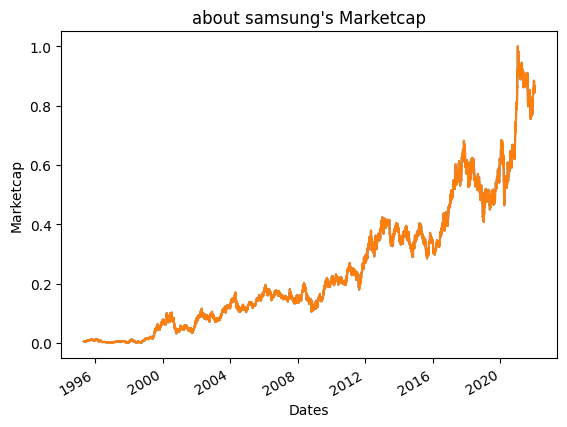

In [15]:
import matplotlib.pyplot as plt

# 시가총액 데이터에 대한 그래프를 생성
plt.plot(df_bt["Marketcap"],'-')
price_plot = df_bt['Marketcap'].plot(style='-')
_ = price_plot.set_title("about samsung's Marketcap")
_ = price_plot.set_xlabel('Dates')
_ = price_plot.set_ylabel('Marketcap')
plt.show()

In [16]:
pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 9.0 MB/s eta 0:00:00


In [17]:
pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.9 MB/s eta 0:00:00


In [19]:
import backtrader as bt
import pygad
class RSI(bt.Strategy):
    params = dict(rsi_low=30,rsi_high=70)
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=21)
        self.rsi_high  = self.p.rsi_high
        self.rsi_low = self.p.rsi_low
    def next(self):
        if not self.position:
            if self.rsi < self.rsi_low:
                self.buy(size=100)
        else:
            if self.rsi > self.rsi_high:
                self.sell(size=100)
PARAM_NAMES = ["rsi_low","rsi_high"]

# 전략의 파라미터인 rsi_low와 rsi_high를 유전 알고리즘으로 탐색하여 수익을 최대화하는 파라미터 조합
def fitness_func(ga_instance, solution, solution_idx):
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, solution)}

    cerebro = bt.Cerebro(stdstats=False)

    data = bt.feeds.PandasData(dataname = df_bt)

    cerebro.adddata(data)

    initial_capital = 1000000
    cerebro.broker.setcash(initial_capital)

    cerebro.addstrategy(RSI, **strategy_params)

    cerebro.addanalyzer(bt.analyzers.DrawDown)

    cerebro.broker.setcommission(commission=0.0025, margin=False)  #수수료 설정

    strats = cerebro.run()

    profit = cerebro.broker.getvalue() - initial_capital
    fitness = profit
    return fitness

fitness_function = fitness_func


num_generations = 5
num_parents_mating = 4

sol_per_pop = 100
num_genes = 2

init_range_low = 0
init_range_high = 100

parent_selection_type = "sss"
keep_parents = 2

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 50

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

In [20]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("solution",solution)

PARAM_NAMES = ["rsi_low","rsi_high"]
fitness_params = {k: v for k, v in zip(PARAM_NAMES, solution)}
#초기자본
startcash = 10000

#Cerebro의 인스턴스를 생성
cerebro = bt.Cerebro()

#strategy 추가
cerebro.addstrategy(RSI,**fitness_params)


data = bt.feeds.PandasData(dataname = df_bt)
#Cerebro에 데이터를 추가
cerebro.adddata(data)

# 원하는 초기 자본을 설정
cerebro.broker.setcash(startcash)

cerebro.run()

#portfolio 수익
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

print('Final Portfolio Value: ${}'.format(portvalue))
print('P/L: ${}'.format(pnl))
print((portvalue-startcash)/startcash*100,'%')

prediction = portvalue-startcash
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [52.50441237 55.33483605]
Fitness value of the best solution = 59.974508696235716
solution [52.50441237 55.33483605]
Final Portfolio Value: $10080.283478260875
P/L: $80.2834782608752
0.802834782608752 %
Predicted output based on the best solution : 80.2834782608752


In [21]:
import csv
#최종 포트폴리오 가치 계산
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#결과
result = {
    'solution':solution,
    'solution_fitness':solution_fitness,
    'solution_idx':solution_idx,
    'Final Portfolio Value': portvalue,
    'P/L': pnl,
    'P/L Percentage': (pnl/startcash) * 100
}

file_path = 'result.csv'

with open(file_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=result.keys())
    writer.writeheader()
    writer.writerow(result)

print(f"Results saved to {file_path} in CSV format.")

Results saved to result.csv in CSV format.


In [22]:
signals = solution
signals[0]

52.50441236883091

In [23]:
# RSI 계산
rsi = talib.RSI(df_bt['Close'])
rsi = pd.DataFrame(rsi).T

# 조건에 따라 값을 할당
rsi[rsi > solution[0]] = -1
rsi[rsi < solution[1]] = 1
rsi[(rsi >= solution[0]) & (rsi <= solution[1])] = 0

# 데이터프레임에 'Signal'이라는 새로운 열을 생성, RSI 값들을 할당하면서 NaN 값을 0
df_bt['Signal'] = rsi.T.fillna(0)

# 데이터프레임을 CSV 파일로 저장
df_bt.to_csv('output.csv', index=False)

In [28]:
k1=pd.read_csv('//content/drive/MyDrive/krx_daydata/Data/output.csv')
k1

,Open,High,Low,Close,Volume,Marketcap,Signal
0,0.042087,0.042072,0.041755,0.030484,0.001545,0.006222,0.0
1,0.041565,0.043985,0.042107,0.031899,0.004241,0.006625,0.0
2,0.043130,0.043289,0.042988,0.031545,0.001944,0.006524,0.0
3,0.042435,0.042942,0.042988,0.031368,0.000525,0.006474,0.0
4,0.042435,0.042420,0.042459,0.031015,0.001017,0.006373,0.0
...,...,...,...,...,...,...,...
6757,0.027409,0.027469,0.026920,0.015596,0.282048,0.849682,1.0
6758,0.026678,0.026982,0.026991,0.015419,0.143201,0.844155,1.0
6759,0.027165,0.027260,0.027273,0.015914,0.167915,0.859629,1.0
6760,0.027165,0.027156,0.027167,0.015808,0.110152,0.856313,1.0


In [30]:
class RSI_E(bt.Strategy):
    params = dict(rsi_high =70, rsi_low = 30)
    def __init__(self):
        self.rsi = bt.indicators.RSI_EMA(self.data.close, period=21)
        self.rsi_high =self.p.rsi_high
        self.rsi_low = self.p.rsi_low
    def next(self):
        if not self.position:
            if self.rsi < self.rsi_low:
                self.buy(size=100)
        else:
            if self.rsi > self.rsi_high:
                self.sell(size=100)
PARAM_NAMES = ["rsi_low","rsi_high"]

# 전략의 파라미터인 rsi_low와 rsi_high를 유전 알고리즘으로 탐색하여 수익을 최대화하는 파라미터 조합
def fitness_func(ga_instance, solution, solution_idx):
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, solution)}

    cerebro = bt.Cerebro(stdstats=False)

    data = bt.feeds.PandasData(dataname = df_bt)

    cerebro.adddata(data)

    initial_capital = 1000000
    cerebro.broker.setcash(initial_capital)

    cerebro.addstrategy(RSI_E, **strategy_params)

    cerebro.addanalyzer(bt.analyzers.DrawDown)

    cerebro.broker.setcommission(commission=0.0025, margin=False)  #수수료 설정

    strats = cerebro.run()

    profit = cerebro.broker.getvalue() - initial_capital
    fitness = profit
    return fitness

fitness_function = fitness_func


num_generations = 5
num_parents_mating = 4

sol_per_pop = 100
num_genes = 2

init_range_low = 0
init_range_high = 100

parent_selection_type = "sss"
keep_parents = 2

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 50

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

In [31]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("solution",solution)

PARAM_NAMES = ["rsi_high","rsi_low"]
fitness_params = {k: v for k, v in zip(PARAM_NAMES, solution)}
#초기자본
startcash = 10000

#Cerebro의 인스턴스를 생성
cerebro = bt.Cerebro()

#strategy 추가
cerebro.addstrategy(RSI_E, **fitness_params)


data = bt.feeds.PandasData(dataname = df_bt)
#Cerebro에 데이터를 추가
cerebro.adddata(data)

# 원하는 초기 자본을 설정
cerebro.broker.setcash(startcash)

# Run over everything
cerebro.run()

#portfolio 수익
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

print('Final Portfolio Value: ${}'.format(portvalue))
print('P/L: ${}'.format(pnl))
print((portvalue-startcash)/startcash*100,'%')

prediction = portvalue-startcash
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [44.90222758 65.1332203 ]
Fitness value of the best solution = 82.89021368219983
solution [44.90222758 65.1332203 ]
Final Portfolio Value: $9983.156965854838
P/L: $-16.843034145162164
-0.16843034145162164 %
Predicted output based on the best solution : -16.843034145162164


In [32]:
import csv
#최종 포트폴리오 가치 계산
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#결과
result2 = {
    'solution':solution,
    'solution_fitness':solution_fitness,
    'solution_idx':solution_idx,
    'Final Portfolio Value': portvalue,
    'P/L': pnl,
    'P/L Percentage': (pnl/startcash) * 100
}

file_path = 'result2.csv'

with open(file_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=result2.keys())
    writer.writeheader()
    writer.writerow(result2)

print(f"Results saved to {file_path} in CSV format.")

Results saved to result2.csv in CSV format.


In [33]:
signals = solution
signals[0]

44.90222757950994

In [34]:
# RSI 계산
rsi_e = talib.RSI(df_bt['Close'])
rsi_e = pd.DataFrame(rsi_e).T

# 조건에 따라 값을 할당
rsi_e[rsi_e > solution[0]] = -1
rsi_e[rsi_e < solution[1]] = 1
rsi_e[(rsi_e >= solution[0]) & (rsi_e <= solution[1])] = 0

# 데이터프레임에 'Signal'이라는 새로운 열을 생성, RSI 값들을 할당하면서 NaN 값을 0
df_bt['Signal'] = rsi_e.T.fillna(0)

df_bt.to_csv('output2.csv', index=False)

In [35]:
k2=pd.read_csv('//content/drive/MyDrive/krx_daydata/Data/output2.csv')
k2

,Open,High,Low,Close,Volume,Marketcap,Signal
0,0.042087,0.042072,0.041755,0.030484,0.001545,0.006222,0.0
1,0.041565,0.043985,0.042107,0.031899,0.004241,0.006625,0.0
2,0.043130,0.043289,0.042988,0.031545,0.001944,0.006524,0.0
3,0.042435,0.042942,0.042988,0.031368,0.000525,0.006474,0.0
4,0.042435,0.042420,0.042459,0.031015,0.001017,0.006373,0.0
...,...,...,...,...,...,...,...
6757,0.027409,0.027469,0.026920,0.015596,0.282048,0.849682,1.0
6758,0.026678,0.026982,0.026991,0.015419,0.143201,0.844155,1.0
6759,0.027165,0.027260,0.027273,0.015914,0.167915,0.859629,1.0
6760,0.027165,0.027156,0.027167,0.015808,0.110152,0.856313,1.0
